# Testing Continuous Epistasis Model Across Pathways

The following code trains and evaluates the continuous epistasis model on a 19 gene pairwise CRISPRi library. It uses single- and pairwise CRISPRi perturbations to relate estimated gene expression (relative repression, estimated from previously gathered qPCR data) to growth rate. Single-gene expression-growth rate relationships are modeled with two-parameter sigmoidal functions, and gene-gene coupling is accounted for using two coupling constants. The resulting model is assessed by its RMSD relative to a coupling-insensitive Null model. Coupling constants are calculated between all genes. As expected, patterns in these couplings broadly correlate with pathway membership. Some interesting trends arise when considering coupling between pathways, or couplings with non-metabolic DNA replication genes. Code adapted from the initial Continuous Epistasis model notebook.

1/19/23 - Ryan Otto
2/16/23 - Ryan Otto
8/29/23 - Ryan Otto

### Import packages and libraries

In [1]:
import numpy as np
import random
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.utils import resample as bootstrap
from scipy import stats
import seaborn as sns
from scipy.stats import linregress
import plot_defaults
plot_defaults.change_defaults()

### Define relevant variables

In [2]:
date = '231012'
input_path = 'input_files'
output_path = 'intermediate_files'
bootstrap_path = 'input_files/bootstrapped_files'
figure_path = 'Figures'
gene_names = ['dapA', 'dapB', 'dapD', 'dapF', 'dnaB', 'dnaE', 'dnaX', 'holB', 'ligA', 'parE', 'purD', 'purL', 'purN',
              'eno', 'fbaA', 'gapA', 'pfkA', 'pgi', 'tpiA']
pathways = {}
pathways['Purine'] = ['purN', 'purL', 'purD']
pathways['Glycolysis'] = ['pfkA', 'pgi', 'tpiA', 'gapA', 'fbaA', 'eno']
pathways['Lysine'] = ['dapD', 'dapF', 'dapA', 'dapB']
pathways['DNA Replication'] = ['parE', 'dnaB', 'dnaX', 'ligA', 'holB', 'dnaE']

### Import data

In [3]:
with open(f'{output_path}/231012_path_df_growth_pool_filt_rescale.pickle', 'rb') as handle:
    growth_df_rescale = pickle.load(handle)
with open(f'{output_path}/231012_path_df_growth_pool_filt_sem_rescale.pickle', 'rb') as handle:
    sem_df_rescale = pickle.load(handle)
with open(f'{output_path}/231012_path_df_growth_pool_filt_std_rescale.pickle', 'rb') as handle:
    std_df_rescale = pickle.load(handle)
with open(f'{output_path}/231012_path_dict_growth_pool.pickle', 'rb') as handle:
    dict_growth_pool = pickle.load(handle)
with open(f'{output_path}/231012_path_gr_min.pickle', 'rb') as handle:
    path_gr_min = pickle.load(handle)    
with open(f'{output_path}/231012_repression_mean.pickle', 'rb') as handle:
    qPCR_vals = pickle.load(handle)
with open(f'{bootstrap_path}/230822_sgRNA_model.pickle', 'rb') as handle:
    MM_hill_est = pickle.load(handle)
with open(f'{bootstrap_path}/230822_hill_est.pickle', 'rb') as handle:
    hill_est = pickle.load(handle)
with open(f'{bootstrap_path}/230822_pair_avals_pathway.pickle', 'rb') as handle:
    pair_avals = pickle.load(handle)
with open(f'{input_path}/pairwise_SID_ecoli.pickle', 'rb') as handle:
    pairSIDEcoli = pickle.load(handle)  # Pairwise sequence identities

### Define analysis functions

In [4]:
def exp_extract(exp_growth_df, rep_mean, gene_name_1, gene_name_2):
    """Function to sort and extract relevant growth rates for a given pair of genes.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    gene_name_1: Name of one gene in the pair
    gene_name_2: Name of the other gene in the pair
    Returns:
    pair_data: Pairwise expression-growth rate data for the gene pair
    gene1: Gene titrated along the index of the pairwise data
    gene2: Gene titrated along the columns of the pairwise data
    """
    for guide in exp_growth_df.index:
        # The following logic establish which gene lies on which axis
        if guide.startswith(gene_name_1):
            gene1 = gene_name_1
            gene2 = gene_name_2
        elif guide.startswith(gene_name_2):
            gene1 = gene_name_2
            gene2 = gene_name_1
    gene1_sgRNAs = list(rep_mean[gene1])
    gene2_sgRNAs = list(rep_mean[gene2])
    pair_data = pd.DataFrame(np.full((len(gene1_sgRNAs), len(gene2_sgRNAs)), np.nan), gene1_sgRNAs, gene2_sgRNAs)
    for sgRNA2 in gene2_sgRNAs:
        for sgRNA1 in gene1_sgRNAs:
            if sgRNA1 == 'negC_rand_42':  # Nontargeting sgRNAs are indexed differently
                 pair_data.loc['negC_rand_42', sgRNA2] = exp_growth_df.loc[sgRNA2, 'negC_rand_42']
            else:
                pair_data.loc[sgRNA1, sgRNA2] = exp_growth_df.loc[sgRNA1, sgRNA2]
    # Sort rows and columns by repression intensity
    pair_data.loc[len(pair_data.index)] = [rep_mean[gene2][sgRNA] for sgRNA in pair_data.columns]
    pair_data = pair_data.sort_values(by=len(pair_data.index)-1, axis=1, ascending=True)
    pair_data = pair_data.drop(labels=len(pair_data.index)-1, axis=0)
    pair_data[len(pair_data.columns)] = [rep_mean[gene1][sgRNA] for sgRNA in pair_data.index]
    pair_data = pair_data.sort_values(by=len(pair_data.columns)-1, axis=0, ascending=True)
    pair_data = pair_data.drop(labels=len(pair_data.columns)-1, axis=1)
    return pair_data, gene1, gene2


def growth_rate(r, Ro, n):
    """Calculates an expected growth rate using a sigmoidal formula.
    Arguments:
    r: Repression level to use when predicting growth rates
    Ro: Repression level at half-maximal growth rate
    n: Steepness of the repression-growth rate function
    Returns:
    g_rate: Predicted growth rate
    """
    if len(r) > 1:  # Check if repression values are a list or just an individual value
        try:
            g_rate = [(1 / (1+math.exp(n*(repression-Ro)))) for repression in r]
        except:
            print('Math range')
            g_rate = [0] * len(r)
    else:
        g_rate = 1 / (1+math.exp(n*(r-Ro)))
    return g_rate

In [5]:
def calc_avals(pairwise_data, rep_mean, hill_params, penalty=0, bounds=[(-1.2, -1.2), (10, 10)]):
    """Optimizes coupling constants for a given pair of genes using pairwise expression-growth rate data.
    Arguments:
    pairwise_data: Pairwise CRISPRi growth rate data to use when fitting a values
    rep_mean: qPCR averages for all single-gene expression perturbations
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    pentalty: Regularization term to penalize the absolute value of coupling constants
    Returns:
    pair_avals: Coupling constants for each gene pair
    """
    pair_avals = {}
    for i, gene_1 in enumerate(list(hill_params)):
        for gene_2 in list(hill_params)[i+1:]:
            gene_pair = (gene_1, gene_2)
            gene1_KD = [rep_mean[gene_pair[1]][treatment1] for treatment1 in pairwise_data[gene_pair].index]
            gene2_KD = [rep_mean[gene_pair[0]][treatment2] for treatment2 in pairwise_data[gene_pair].columns]
            pair_avals[gene_pair] = least_squares(residuals_growthPairs, x0=[0, 0], bounds=bounds,
                                        args=(pairwise_data[gene_pair].values, gene1_KD, gene2_KD,
                                        hill_params[gene_2], hill_params[gene_1], penalty)).x
    return pair_avals


def residuals_growthPairs(avals, y, rep_1, rep_2, p1, p2, penalty):
    """Calculate residuals between pairwise growth rate measurements and predictions.
    The goal is to minimize the regularized RMSD of our predictions. To regularize,
    we add a penalty term based on the absolute values of each parameter in avals.
    Finally, we take the square root of this regularized RMSD, as least_squares technically
    optimizes the squared residual, but we want to minimize the value directly.
    The result of optimization is only numerically (<10**-8) different without the square root.
    Arguments:
    avals: Coupling constants between the genes of interest
    y: True pairwise growth rates
    rep_1: All repression values for gene 1
    rep_2: All repression values for gene 2
    p1: Growth rate parameters Ro and n for gene 1
    p2: Growth rate parameters Ro and n for gene 2
    penalty: Regularization term to penalize the absolute value of coupling constants
    Returns:
    err: Regularized root mean square error between the predicted and measured growth rates
    """
    gpair = pairGrowthRates(avals, rep_1, rep_2, p1, p2)
    mask = ~np.isnan(y.flatten())  # Use to mask nans from input data
    gpair = gpair.flatten()[mask]
    y = y.flatten()[mask]
    err = y - gpair
    err = np.sqrt(nanrms(err) + sum([penalty*abs(x) for x in avals]))
    return err


def pairGrowthRates(avals, rep_1, rep_2, p1, p2):
    """Calculate predicted pairwise growth rates following two coupled gene knockdowns.
    Arguments:
    avals: Coupling constants between the genes of interest
    rep_1: All repression values for gene 1
    rep_2: All repression values for gene 2
    p1: Growth rate parameters Ro and n for gene 1
    p2: Growth rate parameters Ro and n for gene 2
    Returns:
    gr_pair: Predicted pairwise growth rates
    """
    Ro1, n1 = p1
    Ro2, n2 = p2
    r1eff, r2eff, resid_1, resid_2 = solveReff(avals, rep_1, rep_2, Ro1, Ro2)
    # On rare occassions, early rounds of optimization can generate abnormally large effective repression values
    # This logic manually "resets" the optimization, and testing has shown that this is sufficient
    if max([abs(x) for x in r1eff.flatten()]) > 10 or max([abs(x) for x in r2eff.flatten()]) > 10:
        return np.zeros(np.shape(r1eff))
    gr1, gr2, gr_pair = np.zeros(np.shape(r1eff)), np.zeros(np.shape(r2eff)), np.zeros(np.shape(r1eff))
    for i, r1 in enumerate(r1eff):
        gr1[i, :] = growth_rate(r1, Ro1, n1)
    for i, r2 in enumerate(r2eff):
        gr2[i, :] = growth_rate(r2, Ro2, n2)
    for r1 in range(np.shape(r1eff)[0]):
        for r2 in range(np.shape(r1eff)[1]):
            gr_pair[r1, r2] = gr1[r1, r2] * gr2[r1, r2]
    return gr_pair


def solveReff(avals, rep_1, rep_2, Ro_1, Ro_2):
    """Solve for the effective repression of two CRISPRi perturbations given two coupling constants.
    Arguments:
    avals: Coupling constants between the genes of interest
    rep_1: All repression values for gene 1
    rep_2: All repression values for gene 2
    Ro: Growth rate parameter Ro for gene 1
    Ro: Growth rate parameter Ro for gene 2
    Returns:
    r1eff: 2D array of the first perturbation's relative repression after accounting for coupling
    r1eff: 2D array of the second perturbation's relative repression after accounting for coupling
    resids_r1: List of residuals for the first perturbation, returned for troubleshooting and optimization
    resids_r2: List of residuals for the second perturbation, returned for troubleshooting and optimization
    """
    r1eff = np.tile(np.array(rep_1), (len(rep_2), 1)).T
    r2eff = np.tile(np.array(rep_2), (len(rep_1), 1))
    r1update, r2update = np.zeros(np.shape(r1eff)), np.zeros(np.shape(r2eff))
    resids, eps, count = np.inf, 0.01, 0  # Initialize sum of residuals, desired final residual, and count iterator
    resids_r1, resids_r2 = [], []
    # Iteratively reduce the residuals using the update formulas
    # If the desired residual is not reached, exit after 100 iterations
    while resids > eps and count < 100:
        for i, r1 in enumerate(rep_1):
            for j, r2 in enumerate(rep_2):
                r1update[i, j] = r1 / (1 + avals[0]*((r2eff[i, j]/Ro_2)/(1 + (r2eff[i, j]/Ro_2))))
                r2update[i, j] = r2 / (1 + avals[1]*((r1eff[i, j]/Ro_1)/(1 + (r1eff[i, j]/Ro_1))))
        resids_r1.append(np.sum(abs(r1eff - r1update)))
        resids_r2.append(np.sum(abs(r2eff - r2update)))
        resids = resids_r1[-1] + resids_r2[-1]
        r1eff = np.copy(r1update)
        r2eff = np.copy(r2update)
        count += 1
    return r1eff, r2eff, resids_r1, resids_r2


def nanrms(x, axis=None):
    """Self-defined root mean square function. Used for convenience and consistency.
    Arguments:
    x: Array of residuals
    axis: In case of an array of arrays, enter the desired axis to calculate across
    Directly returns the RMSD of the residuals provided
    """
    return np.sqrt(np.nanmean(x**2, axis=axis))


def pred_mult_calculate(exp_growth_df):
    """Calculate predicted pairwise growth rates using a multiplicative Bliss model
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    Returns:
    mult_gr: Predicted growth rates from a multiplicative Bliss model
    """
    mult_gr = pd.DataFrame(np.full((len(exp_growth_df.index), len(exp_growth_df.columns)), np.nan),
                           exp_growth_df.index, exp_growth_df.columns)
    for sgRNA1 in exp_growth_df.index:
        for sgRNA2 in exp_growth_df.columns:
            mult_gr.loc[sgRNA1, sgRNA2] = exp_growth_df['negC_rand_42'][sgRNA1]*exp_growth_df[sgRNA2]['negC_rand_42']
    return mult_gr

In [6]:
def calc_pair_gr(exp_growth_df, rep_mean, avals, pairwise_data, hill_params):
    """Calculate growth rates following pairwise CRISPRi for all gene pairs.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    avals: Coupling constants for each gene pair
    pairwise_data: Pairwise CRISPRi growth rate data
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    Returns:
    pred_dict: All predicted growth rates
    """
    pred_dict = {}
    for gene_pair in avals:
        pair_gr, gene1, gene2 = exp_extract(exp_growth_df, rep_mean, gene_pair[0], gene_pair[1])
        gene1_KD = [rep_mean[gene_pair[1]][treatment1] for treatment1 in pairwise_data[gene_pair].index]
        gene2_KD = [rep_mean[gene_pair[0]][treatment2] for treatment2 in pairwise_data[gene_pair].columns]
        pred_dict[gene_pair] = pairGrowthRates(avals[gene_pair], gene1_KD, gene2_KD, hill_params[gene1],
                                               hill_params[gene2])
    return pred_dict


def heat_map(df, ax=None, xticks=None, yticks=None, xlabel=None, ylabel=None, vmin=0, vmax=2, cmap='PuOr_r'):
    """Creates a heat map. Function made for ease of use.
    Arguments: 
    df: Data to plpot
    ax: Axes object, if available
    xticks, yticks, xlabel, ylabel, vmin, vmax, cmap: Self-explanatory
    Returns:
    ax: Resulting axes object
    cb: Colorbar
    """
    if not ax:
        ax = plt.gca()
    cb = ax.imshow(df, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    if xticks:
        ax.set_xticks(np.arange(len(xticks)))
        ax.set_xticklabels(xticks, fontsize=18, rotation=90)
        ax.xaxis.tick_top()
    else:
        ax.set_xticks([])
    if yticks:
        ax.set_yticks(np.arange(len(yticks)))
        ax.set_yticklabels(yticks, fontsize=18)
    else:
        ax.set_yticks([])
    ax.spines[['top', 'right']].set_visible(True)
    ax.set_facecolor("darkgrey")
    return ax, cb


def extract_gr_pairs(exp_growth_df, rep_mean, hill_params):
    """Generates two groups of pairwise expression-growth rate data.
    The first group includes all data gathered in the pairwise experiment.
    The second contains only growth rates following two targeting CRISPRi perturbations.
    Arguments:
    exp_growth_df: Growth rate averages for all single-gene expression perturbations
    rep_mean: qPCR averages for all single-gene expression perturbations
    hill_params: Best fit parameters for each gene's expression-growth rate sigmoid fit
    Returns:
    full_data: The first group of data, containing all measurements
    pairwise_data: The second group of data, containing only pairwise measurements
    """
    full_data, pairwise_data = {}, {}
    for i, gene_1 in enumerate(list(hill_params)):
        for gene_2 in list(hill_params)[i+1:]:
            gene_pair = (gene_1, gene_2)
            full_data[gene_pair], gene1, gene2 = exp_extract(exp_growth_df, rep_mean, gene_1, gene_2)
            ind_names, col_names = full_data[gene_pair].index, full_data[gene_pair].columns
            gene1_KD = [rep_mean[gene_pair[1]][treatment1] for treatment1 in full_data[gene_pair].index]
            gene2_KD = [rep_mean[gene_pair[0]][treatment2] for treatment2 in full_data[gene_pair].columns]
            pairwise_data[gene_pair] = full_data[gene_pair].copy()  # Don't change the original
            pairwise_data[gene_pair].loc['negC_rand_42'] = np.nan  # Remove first-order perturbations
            pairwise_data[gene_pair]['negC_rand_42'] = np.nan  # Remove first-order perturbations
    return full_data, pairwise_data

## Estimate sgRNA repression efficiency using qPCR data
The basis of CRISPRi is the existence of a monotonic relationship between the number of mismatches with an sgRNA homology region and the repression efficiency of the given sgRNA. With this in mind, we train a simple, sigmoidal model relating the number of mismatches to an sgRNA's repression efficiency relative to the "parent" (fully on-target) sgRNA it was derived from. This simple model has the benefit of being trained on the qPCR data gathered in previous studies, which has been demonstrated to reliably predict growth rate effect. Other, more complex models for estimating sgRNA efficacy exist, however none to this point have been trained directly on qPCR data. We bootstrap this model fit and propagate its uncertainty throughout our predictions.

In [7]:
rel_effect_dict = {i:[] for i in range(15)}
rel_effect_dict[0] = [1]  # A fully on-target sgRNA has 0 mismatches and a relative repression effeciency of 1
for _, sgRNAs in qPCR_vals.items():
    for sgRNA in sgRNAs:
        if '_C' not in sgRNA and 'negC' not in sgRNA:
            sp = sgRNA.split('_')
            MM = int(sp[-1][2:])
            rel_effect_dict[MM].append(qPCR_vals[sp[0]][sgRNA]/qPCR_vals[sp[0]][f'{sp[0]}_{sp[1]}_{sp[2]}_C'])

### Note: 
As bootstrapping is inherently random, we've saved the results of one bootstrapping iteration and commented out this code block. Uncommenting it will generate distinct curves that will differ slightly from our reported results.

In [8]:
"""
num_boot = 100
MM_hill_est, xdata, ydata = {}, [], []
bars = [np.mean(x) for x in rel_effect_dict.values()]
for MM, vals in rel_effect_dict.items():
    for repression in vals:
        xdata.append(MM)
        ydata.append(repression)
for boot in range(num_boot):
    xb, yb = bootstrap(xdata, ydata)
    MM_hill_est[boot], _ = curve_fit(growth_rate, xb, yb, p0=[5, 1], bounds=[(0, -np.inf), (np.inf, np.inf)])
MM_hill_est['Full Fit'], _ = curve_fit(growth_rate, rel_effect_dict.keys(), bars, p0=[10, 1], bounds=[(0, -np.inf),
                                                                                              (np.inf, np.inf)])
with open(f'{bootstrap_path}/{date}_sgRNA_model.pickle', 'wb') as handle:
    pickle.dump(MM_hill_est, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

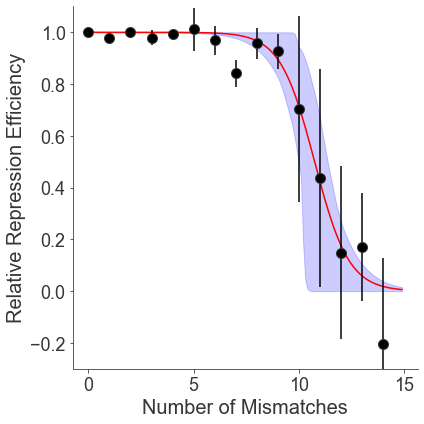

In [9]:
bars = [np.mean(x) for x in rel_effect_dict.values()]
err = [np.std(x) if len(x) > 1 else 0 for x in rel_effect_dict.values()]
xVals, fitVal_list = np.arange(0, 15, 0.1), []
yVals = growth_rate(xVals, MM_hill_est['Full Fit'][0], MM_hill_est['Full Fit'][1])
for i in MM_hill_est:
    if i != 'Full Fit':
        fitVal_list.append(growth_rate(xVals, MM_hill_est[i][0], MM_hill_est[i][1]))
low_q, high_q = [], []
for i in range(len(xVals)):
    low_q.append(np.quantile([x[i] for x in fitVal_list], 0.025))
    high_q.append(np.quantile([x[i] for x in fitVal_list], 0.975))
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(xVals, yVals, color='r')
ax.errorbar(rel_effect_dict.keys(), bars, yerr=err, fmt='o', mec='xkcd:dark gray', color='k', ms=10)
ax.fill_between(xVals, low_q, high_q, alpha=0.2, color='b', label='95% CI')
ax.set_ylim([-0.3, 1.1])
ax.set_xlabel('Number of Mismatches', fontsize=20)
ax.set_ylabel('Relative Repression Efficiency', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS6C.pdf')
plt.show()

### Estimate mRNA concentration and uncertainty using the model

In [10]:
qPCR_est = {gene:{'negC_rand_42':0} for gene in gene_names}
qPCR_ind = {gene:{'negC_rand_42':[0]} for gene in gene_names}
qPCR_sem = {gene:{'negC_rand_42':0} for gene in gene_names}
for sgRNA in growth_df_rescale.index:
    if 'negC' not in sgRNA:
        gene = sgRNA.split('_')[0]
        if sgRNA.endswith('C'):
            MM = 0
        else:
            MM = int(sgRNA.split('_')[-1][2:])
        qPCR_est[gene][sgRNA] = growth_rate([MM, 0], MM_hill_est['Full Fit'][0], MM_hill_est['Full Fit'][1])[0]
        qPCR_ind[gene][sgRNA] = []        
        for boot in MM_hill_est:
            if boot != 'Full Fit':
                qPCR_ind[gene][sgRNA].append(growth_rate([MM, 0], MM_hill_est[boot][0], MM_hill_est[boot][1])[0])
        qPCR_sem[gene][sgRNA] = stats.sem(qPCR_ind[gene][sgRNA])

### Fit single expression-growth curves

We fit individual sigmoids to our single-gene expression-growth rate data. These sigmoids are described by two parameters, $R_0$ (repression at half-maximal growth rate) and n (steepness).

In addition to fitting each gene's expression-growth curve using all of our experimental data ('Full Fit'), we also estimated the uncertainty in these curves by bootstrapping experimental replicates of both our qPCR-based expression measurements and our NGS-based growth rate measurements (100 bootstrapping iterations). This ensures that our model's performance is not sensitive to sgRNA identity -- as leaving some measurements out (while over-weighting others) produces comparable single-gene fits. The shaded region is a 95% confidence interval (CI) of all bootstrapped curves. The uncertaity in single-gene fits is propagated through all analysis -- presented as a confidence interval (coupling constants, RMSDs, AICs) or standard deviations (growth rate predictions). Genes are grouped by epistatic cluster.

### Note: 
As bootstrapping is inherently random, we've saved the results of one bootstrapping iteration and commented out this code block. Uncommenting it will generate distinct curves that will differ slightly from our reported results.

In [11]:
"""
num_boot = 100
fitVal_list, hill_est, xVals = {}, {i:{} for i in list(range(num_boot)) + ['Full Fit']}, np.arange(-2, 1.5, 0.01)
for iterator, gene in enumerate(gene_names):
    row, col = int(iterator/3), iterator%3
    fitVal_list[gene], xmean, ymean = [], [], []
    for sgRNA in dict_growth_pool:  # Full fit
        if sgRNA.startswith(gene) or sgRNA == 'negC_rand_42':
            if ~np.isnan(growth_df_rescale.loc[sgRNA, 'negC_rand_42']):
                xmean.append(qPCR_est[gene][sgRNA])
                ymean.append(growth_df_rescale.loc[sgRNA, 'negC_rand_42'])
    hill_est['Full Fit'][gene], _ = curve_fit(growth_rate, xmean, ymean, p0=[0.5, 1], bounds=[(0, -np.inf),
                                                                                              (np.inf, np.inf)])
    for i in range(num_boot):
        xdata, ydata = [], []
        for sgRNA in dict_growth_pool:
            if sgRNA.startswith(gene) or sgRNA == 'negC_rand_42':
                # Randomly select a qPCR replicate for each growth rate replicate. This randomizes every iteration
                xdata += random.choices(qPCR_ind[gene][sgRNA], k=len(dict_growth_pool['negC_rand_42'][sgRNA]))
                # Make sure to rescale individual growth rate mesurements
                ydata += list((dict_growth_pool['negC_rand_42'][sgRNA]-path_gr_min)/(abs(path_gr_min)))
        xb, yb = bootstrap(xdata, ydata)
        hill_est[i][gene], _ = curve_fit(growth_rate, xb, yb, p0=[0.5, 1], bounds=[(0, -np.inf), (np.inf, 1000)],
                                         maxfev=5000)
with open(f'{bootstrap_path}/{date}_hill_est.pickle', 'wb') as handle:
    pickle.dump(hill_est, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

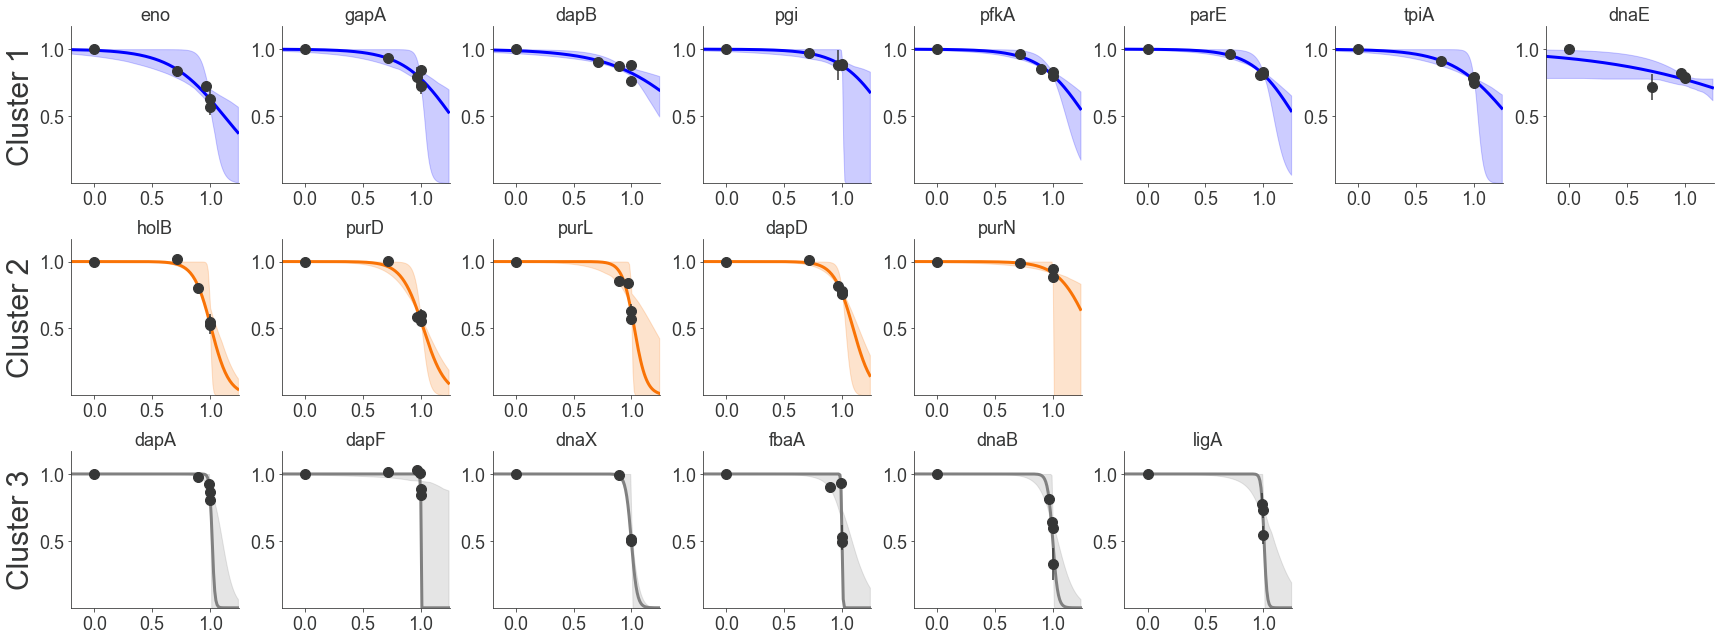

In [12]:
clusters = {}
clusters['Cluster 1'] = ['eno', 'gapA', 'dapB', 'pgi', 'pfkA', 'parE', 'tpiA', 'dnaE']
clusters['Cluster 2'] = ['holB', 'purD', 'purL', 'dapD', 'purN']
clusters['Cluster 3'] = ['dapA', 'dapF', 'dnaX', 'fbaA', 'dnaB', 'ligA']
color_dict = {'Cluster 1':'b', 'Cluster 2':'xkcd:orange', 'Cluster 3':'gray'}
fig, ax = plt.subplots(3, 8, figsize=(24, 9))
for row, (group, gene_namess) in enumerate(clusters.items()):
    fitVal_list = {}
    for iterator, gene in enumerate(gene_namess):
        fitVal_list[gene], xmean, xerr, ymean, yerr = [], [], [], [], []
        for sgRNA in dict_growth_pool:
            if sgRNA.startswith(gene) or sgRNA == 'negC_rand_42':
                xmean.append(qPCR_est[gene][sgRNA])
                xerr.append(qPCR_sem[gene][sgRNA])
                ymean.append(growth_df_rescale.loc[sgRNA, 'negC_rand_42'])
                yerr.append(sem_df_rescale.loc[sgRNA, 'negC_rand_42'])
        # Pick the best x-axis limit for a given gene
        temp_floor = -0.2
        xVals = np.arange(temp_floor, 1.25, 0.01)
        for i in hill_est:
            if i != 'Full Fit':
                fitVal_list[gene].append(growth_rate(xVals, hill_est[i][gene][0], hill_est[i][gene][1]))
        low_q, high_q = [], []
        for i in range(len(xVals)):
            low_q.append(np.quantile([x[i] for x in fitVal_list[gene]], 0.025))
            high_q.append(np.quantile([x[i] for x in fitVal_list[gene]], 0.975))
        fitVals = growth_rate(xVals, hill_est['Full Fit'][gene][0], hill_est['Full Fit'][gene][1])
        ax[row, iterator].plot(xVals, fitVals, ls='-', color=color_dict[group], lw=3, label='Model Fit')
        ax[row, iterator].fill_between(xVals, low_q, high_q, alpha=0.2, color=color_dict[group], label='95% CI')
        #ax[row, col].legend()
        ax[row, iterator].errorbar(xmean, ymean, xerr=xerr, yerr=yerr, fmt='o', color='xkcd:dark gray', ms=10)
        ax[row, iterator].set_xlim(temp_floor, 1.25)
        ax[row, iterator].set_ylim([0, 1.17])
        ax[row, iterator].set_yticks([0.5, 1])
        ax[row, iterator].set_title(gene, fontsize=18)
        if iterator == 0:
            ax[row, iterator].set_ylabel(group, fontsize=30)
    while iterator < 7:
        iterator += 1
        fig.delaxes(ax[row, iterator])
plt.tight_layout()
plt.savefig(f'{figure_path}/Fig5E.pdf')
plt.show()

### Fit coupling constants and calculate predicted growth rates

We fit coupling constants to pairwise expression-growth rate data, then use these coupling constants and single-gene sigmoid parameters to generate predicted growth rates for each CRISPRi perturbation. We also predict growth rates using subsampled pairwise growth rate data as well as a Null model without coupling and a multiplicative model that considers only sgRNA identity and cannot make predictions based on expression changes.

Note: As this code block is repeated 101 times (once for the full model fit, 100 times for bootstrapped replicates), we've saved its output and read it in above. Assuming the same single-gene curves (hill_est) are used as inputs, it will results in the same output as that we have saved.

In [13]:
"""
pair_avals, reg = {}, 10**-1.25
fit_gene_all, fit_gene_pairs = extract_gr_pairs(growth_df_rescale, qPCR_est, hill_est['Full Fit'])
for idx in hill_est:
    pair_avals[idx] = calc_avals(fit_gene_pairs, qPCR_est, hill_est[idx], reg)
    print(idx)
with open(f'{bootstrap_path}/{date}_pair_avals_pathway.pickle', 'wb') as handle:
    pickle.dump(pair_avals, handle, protocol=pickle.HIGHEST_PROTOCOL)
"""
pass

### Fit continuous epistasis model with only one coupling constant

To evaluate hierarchy between genes, we fit the CE model while allowing only one coupling constant to float at a time. This was done by bounding the second coupling constant to 0, then fitting and assessing the model as usual.

In [14]:
pair_avals_solo, reg = {0:None, 1:None}, 10**-1.25
fit_gene_all, fit_gene_pairs = extract_gr_pairs(growth_df_rescale, qPCR_est, hill_est['Full Fit'])
for idx in ['Full Fit']:
    pair_avals_solo[0] = calc_avals(fit_gene_pairs, qPCR_est, hill_est[idx], reg, [(-1.2, -10**-10), (10, 0)])
    pair_avals_solo[1] = calc_avals(fit_gene_pairs, qPCR_est, hill_est[idx], reg, [(-10**-10, -1.2), (0, 10)])
    print(idx)

Full Fit


### Calculate model performance

For all predictions, we two calculate error metrics: AIC and RMSD. AIC accounts for the difference in the number of parameters between models, penalizing those with additional parameters, while RMSD is blind to these differences. We see that the full model outperforms all others, even when accounting for its additional parameters.

We report the model's true RMSD and AIC using our complete fit and estimate 95% confidence intervals for these error metrics using the 100 bootstrapped replicates.

In [15]:
pred_dict, pred_dict_null, rms_dict, rms_dict_null, pair_avals_null, mult_pred, pred_dict_solo, rms_dict_solo = \
                                                                        {}, {}, {}, {}, {}, {}, {}, {0:{}, 1:{}}
# Calculate the number of fit parameters for each model
epi_k = 2*(len(hill_est['Full Fit'])) + 2*len(pair_avals['Full Fit'])
null_k = 2*(len(hill_est['Full Fit']))
mult_k = 0
fit_gene_all, fit_gene_pairs = extract_gr_pairs(growth_df_rescale, qPCR_est, hill_est['Full Fit'])
boot_rms_epi, boot_rms_mult, boot_rms_null, boot_AIC_epi, boot_AIC_mult, boot_AIC_null = [], [], [], [], [], []
for gene_pair in pair_avals['Full Fit']:
    mult_pred[gene_pair] = pred_mult_calculate(fit_gene_all[gene_pair])
    pair_avals_null[gene_pair] = np.array([0, 0])
for idx in pair_avals:
    pred_dict[idx] = calc_pair_gr(growth_df_rescale, qPCR_est, pair_avals[idx], fit_gene_all, hill_est[idx])
    pred_dict_null[idx] = calc_pair_gr(growth_df_rescale, qPCR_est, pair_avals_null, fit_gene_all, hill_est[idx])
    rms_dict[idx], rms_dict_null[idx] = {}, {}
    pred_dict_solo[0] = calc_pair_gr(growth_df_rescale, qPCR_est, pair_avals_solo[0], fit_gene_all, hill_est[idx])
    pred_dict_solo[1] = calc_pair_gr(growth_df_rescale, qPCR_est, pair_avals_solo[1], fit_gene_all, hill_est[idx])
    full_epi_err, full_mult_err, full_null_err = [], [], []
    for gene_pair in pair_avals[idx]:
        expt_genepair = fit_gene_all[gene_pair].values
        pred_mult_genepair = mult_pred[gene_pair].values
        err_mult, err_epi, err_null, err_epi_solo_0, err_epi_solo_1 = [], [], [], [], []
        for j, guide2 in enumerate(list(fit_gene_all[gene_pair].index)):
            if guide2 != 'negC_rand_42':  # Not single-order data
                for k, guide1 in enumerate(list(fit_gene_all[gene_pair].columns)):
                    if guide1 != 'negC_rand_42':  # Not single-order data
                        err_mult.append(expt_genepair[j, k] - pred_mult_genepair[j, k])
                        err_epi.append(expt_genepair[j, k] - pred_dict[idx][gene_pair][j, k])
                        err_null.append(expt_genepair[j, k] - pred_dict_null[idx][gene_pair][j, k])
                        err_epi_solo_0.append(expt_genepair[j, k] - pred_dict_solo[0][gene_pair][j, k])
                        err_epi_solo_1.append(expt_genepair[j, k] - pred_dict_solo[1][gene_pair][j, k])
        full_epi_err += err_epi
        full_mult_err += err_mult
        full_null_err += err_null
        rms_dict[idx][gene_pair] = nanrms(np.array(err_epi))
        rms_dict_null[idx][gene_pair] = nanrms(np.array(err_null))
        rms_dict_solo[0][gene_pair] = nanrms(np.array(err_epi_solo_0))
        rms_dict_solo[1][gene_pair] = nanrms(np.array(err_epi_solo_1))
    if idx == 'Full Fit':
        full_epi_rmsd = nanrms(np.array(full_epi_err))
        full_mult_rmsd = nanrms(np.array(full_mult_err))
        full_null_rmsd = nanrms(np.array(full_null_err))
        full_epi_AIC = 2*epi_k + sum(~np.isnan(full_epi_err))*np.log(np.nanmean([x**2 for x in full_epi_err]))
        full_mult_AIC = 2*mult_k + sum(~np.isnan(full_mult_err))*np.log(np.nanmean([x**2 for x in full_mult_err]))
        full_null_AIC = 2*null_k + sum(~np.isnan(full_null_err))*np.log(np.nanmean([x**2 for x in full_null_err]))
    else:
        boot_rms_epi.append(nanrms(np.array(full_epi_err)))
        boot_rms_mult.append(nanrms(np.array(full_mult_err)))
        boot_rms_null.append(nanrms(np.array(full_null_err)))
        boot_AIC_epi.append(2*epi_k \
                           + sum(~np.isnan(full_epi_err))*np.log(np.nanmean([x**2 for x in full_epi_err])))
        boot_AIC_mult.append(2*mult_k \
                          + sum(~np.isnan(full_mult_err))*np.log(np.nanmean([x**2 for x in full_mult_err])))
        boot_AIC_null.append(2*null_k \
                          + sum(~np.isnan(full_null_err))*np.log(np.nanmean([x**2 for x in full_null_err])))
for (title, data, full) in zip(['Epistatic', 'Null', 'Bliss'],
                                       [boot_rms_epi, boot_rms_null, boot_rms_mult],
                                       [full_epi_rmsd, full_null_rmsd, full_mult_rmsd]):
    print(f'{title} model RMSD, [95% CI]: '
    f'{np.round(full, 3)}, [{np.round(np.quantile(data, 0.025), 3)}, {np.round(np.quantile(data, 0.975), 3)}]',
          end='\n\n')
for (title, data, full) in zip(['Epistatic', 'Null', 'Bliss'],
                                       [boot_AIC_epi, boot_AIC_null, boot_AIC_mult],
                                       [full_epi_AIC, full_null_AIC, full_mult_AIC]):
    print(f'{title} model AIC, [95% CI]: '
    f'{np.round(full)}, [{np.round(np.quantile(data, 0.025))}, {np.round(np.quantile(data, 0.975))}]')

Epistatic model RMSD, [95% CI]: 0.059, [0.063, 0.083]

Null model RMSD, [95% CI]: 0.117, [0.096, 0.121]

Bliss model RMSD, [95% CI]: 0.122, [0.122, 0.122]

Epistatic model AIC, [95% CI]: -15320.0, [-15016.0, -13448.0]
Null model AIC, [95% CI]: -12133.0, [-13260.0, -11941.0]
Bliss model AIC, [95% CI]: -11445.0, [-11445.0, -11445.0]


tpiA->pgi, 0.883
gapA->pgi, 1.468
eno->pgi, 1.043
tpiA->pfkA, 1.197
gapA->pfkA, 1.501
eno->pfkA, 2.752
tpiA->gapA, 1.635
eno->tpiA, 1.47
eno->gapA, 1.755
purD->purL, 0.351
dapD->dapB, 0.582
parE->dnaE, 1.584
holB->parE, 0.628
holB->dnaE, 0.41
holB->dnaX, 0.352


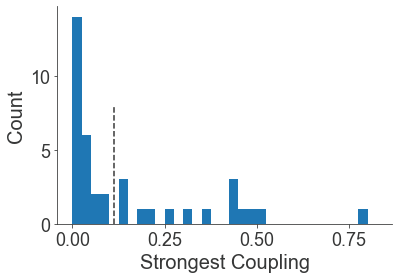

In [16]:
cutoff, coupling_constants = 0.1, []
glycolysis_order = ['pgi', 'pfkA', 'fbaA', 'tpiA', 'gapA', 'eno']
purine_order = ['purD', 'purN', 'purL']
lysine_order = ['dapA', 'dapB', 'dapD', 'dapF']
rep_order = ['parE', 'dnaB', 'dnaE', 'dnaX', 'holB', 'ligA']
for idx, (pathway, genes) in enumerate(zip(
    ['Glycolysis', 'Purine', 'Lysine', 'Replication'], [glycolysis_order, purine_order, lysine_order, rep_order])):
    for i, gene1 in enumerate(genes):
        for gene2 in genes[i+1:]:
            gene_pair_f = (gene1, gene2)
            gene_pair_r = (gene2, gene1)
            if gene_pair_f in pair_avals['Full Fit']:  # Reformat coupling based on direction in pathway
                forward = rms_dict_solo[0][gene_pair_f]
                reverse = rms_dict_solo[1][gene_pair_f]
                aval_f = pair_avals_solo[0][gene_pair_f][0]
                aval_r = pair_avals_solo[1][gene_pair_f][1]
            else:  # Reformat coupling based on direction in pathway
                forward = rms_dict_solo[1][gene_pair_r]
                reverse = rms_dict_solo[0][gene_pair_r]
                aval_f = pair_avals_solo[1][gene_pair_r][1]
                aval_r = pair_avals_solo[0][gene_pair_r][0]
            if forward < reverse:  # Evaalute coupling directionality
                aval, arrow = aval_f, f'{gene2}->{gene1}'
            else:  # Evaalute coupling directionality
                aval, arrow = aval_r, f'{gene1}->{gene2}'
            if aval > cutoff:  # Cutoff for meaningful coupling
                print(f'{arrow}, {np.round((aval-cutoff)/(0.85-cutoff)*2.75 + 0.25, 3)}')  # Output arrow width
            coupling_constants.append(aval)
plt.hist(coupling_constants, bins=np.arange(0, 0.85, 0.025))
plt.xlabel('Strongest Coupling', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.yticks([0, 5, 10])
plt.xticks([0, 0.25, 0.5, 0.75])
plt.vlines(cutoff+0.0125, 0, 8, ls='--', color='xkcd:dark gray')
plt.savefig(f'{figure_path}/FigS6E.pdf')
plt.show()

### Plot continuous epistasis model performance against Null model performance for all gene pairs

We plot the prediction RMSD across every gene pair for both the complete continuous epistasis model and the Null model. The continuous epistasis model (trained on all data or subsampled) is equivalent or superior to the Null model for all gene pairs (which is expected), and approaches the limit of experimental reproducibility. Error bars represent the standard deviation of model error across bootstrapped replicates.

We also calculate the Pearson's correlation coefficient between each gene's epistatic 

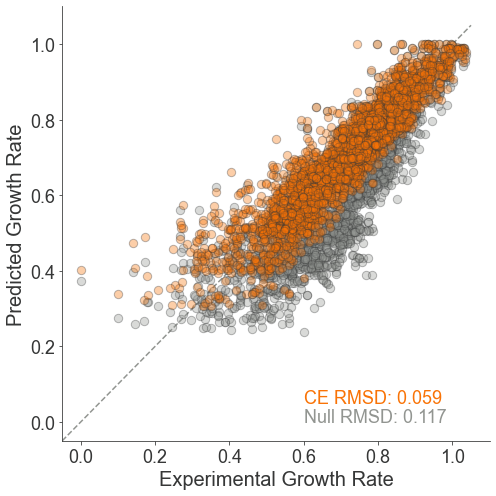

In [17]:
CE_pred, null_pred, true_data = [], [], []
for gene_pair in pred_dict['Full Fit']:
    for i, sgRNA1 in enumerate(fit_gene_pairs[gene_pair].index):
        for j, sgRNA2 in enumerate(fit_gene_pairs[gene_pair].columns):
            if ~np.isnan(fit_gene_pairs[gene_pair].loc[sgRNA1, sgRNA2]):
                CE_pred.append(pred_dict['Full Fit'][gene_pair][i, j])
                true_data.append(fit_gene_pairs[gene_pair].loc[sgRNA1, sgRNA2])
                null_pred.append(pred_dict_null['Full Fit'][gene_pair][i, j])
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(true_data, CE_pred, color='xkcd:orange', alpha=0.35, zorder=2, ec='xkcd:dark gray', s=70)
ax.text(0.6, 0.05, f'CE RMSD: {np.round(nanrms(np.array(true_data)-np.array(CE_pred)), 3)}', fontsize=18,
        color='xkcd:orange')
ax.set_ylabel('Predicted Growth Rate', fontsize=20)
ax.scatter(true_data, null_pred, color='xkcd:gray', alpha=0.35, zorder=1, ec='xkcd:dark gray', s=70)
ax.text(0.6, 0, f'Null RMSD: {np.round(nanrms(np.array(true_data)-np.array(null_pred)), 3)}', fontsize=18,
        color='xkcd:gray')
ax.plot([-0.05, 1.05], [-0.05, 1.05], zorder=0, ls='--', color='xkcd:gray')
ax.set_xlim([-0.05, 1.1])
ax.set_ylim([-0.05, 1.1])
ax.set_xlabel('Experimental Growth Rate', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_path}/Fig5F.pdf')
plt.show()

### Visualize epistasis from the continuous epistasis model and a simple Bliss epistasis

Coupling values derived from the continuous epistasis model are shown. In addition, Bliss epistasis is calculated for the most severe knockdowns (this approximates a classical knockout study, where epistasis is calculated only at this severe perturbation level). We see that gene-gene epistasis may be most prevalent at these extreme levels, potentially due to a decrease in the signal-to-noise ratio we observe at these low growth rates. When considering the entire expression-growth rate landscape, which we approximate with numerous titrated CRISPRi measurements, gene-gene epistasis is fairly rare.

/Applications/miniconda3/envs/p39workshop/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


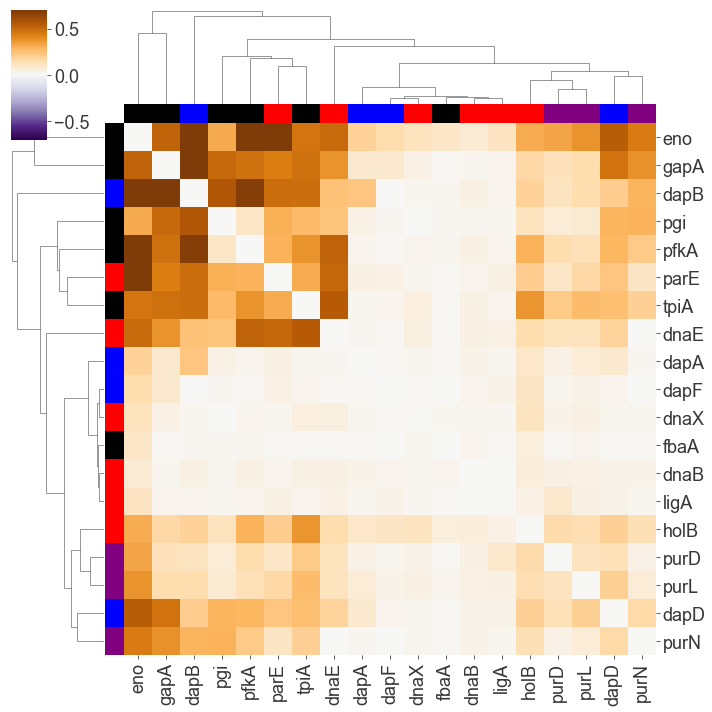

In [18]:
row_colors, color_dict = [], {'Glycolysis':'k', 'Purine':'purple', 'Lysine':'b', 'DNA Replication':'r'}
for gene in gene_names:
    for group in pathways:
        if gene in pathways[group]:
            row_colors.append(color_dict[group])
avals_sum = pd.DataFrame(np.zeros((len(gene_names), len(gene_names))), gene_names, gene_names)
for gene_pair in pair_avals['Full Fit']:
    avals_sum.loc[gene_pair[0], gene_pair[1]] = abs(pair_avals['Full Fit'][gene_pair][0]) \
    + abs(pair_avals['Full Fit'][gene_pair][1])
    avals_sum.loc[gene_pair[1], gene_pair[0]] = abs(pair_avals['Full Fit'][gene_pair][0]) \
    + abs(pair_avals['Full Fit'][gene_pair][1])
sns.clustermap(avals_sum, vmin=-0.7, vmax=0.7, cmap='PuOr_r', dendrogram_ratio=0.15, row_colors=row_colors,
              col_colors=row_colors)
plt.savefig(f'{figure_path}/Fig5G_Dendro.pdf')
plt.show()

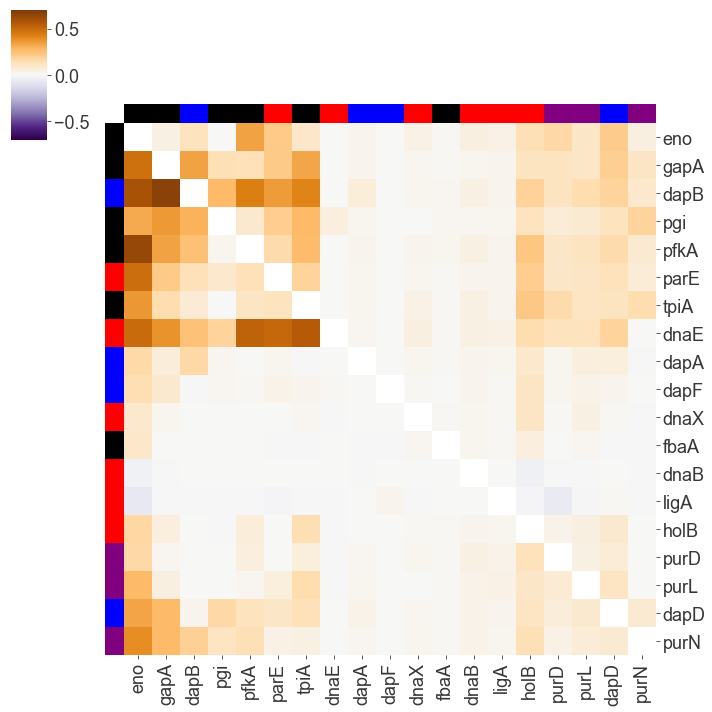

In [19]:
gene_order = ['eno', 'gapA', 'dapB', 'pgi', 'pfkA', 'parE', 'tpiA', 'dnaE', 'dapA', 'dapF', 'dnaX', 'fbaA', 'dnaB',
               'ligA', 'holB', 'purD', 'purL', 'dapD', 'purN']
row_colors_clust = []
for gene in gene_order:
    for group in pathways:
        if gene in pathways[group]:
            row_colors_clust.append(color_dict[group])
avals = pd.DataFrame(np.zeros((len(gene_order), len(gene_order))), gene_order, gene_order)
for gene_pair in pair_avals['Full Fit']:
    avals.loc[gene_pair[0], gene_pair[1]] = pair_avals['Full Fit'][gene_pair][0]
    avals.loc[gene_pair[1], gene_pair[0]] = pair_avals['Full Fit'][gene_pair][1]
for gene in gene_names:
    avals.loc[gene, gene] = np.nan
sns.clustermap(avals, vmin=-0.7, vmax=0.7, cmap='PuOr_r', dendrogram_ratio=0.15, row_colors=row_colors_clust,
              col_colors=row_colors_clust, row_cluster=False, col_cluster=False)
plt.savefig(f'{figure_path}/Fig5G_heatmap.pdf')
plt.show()

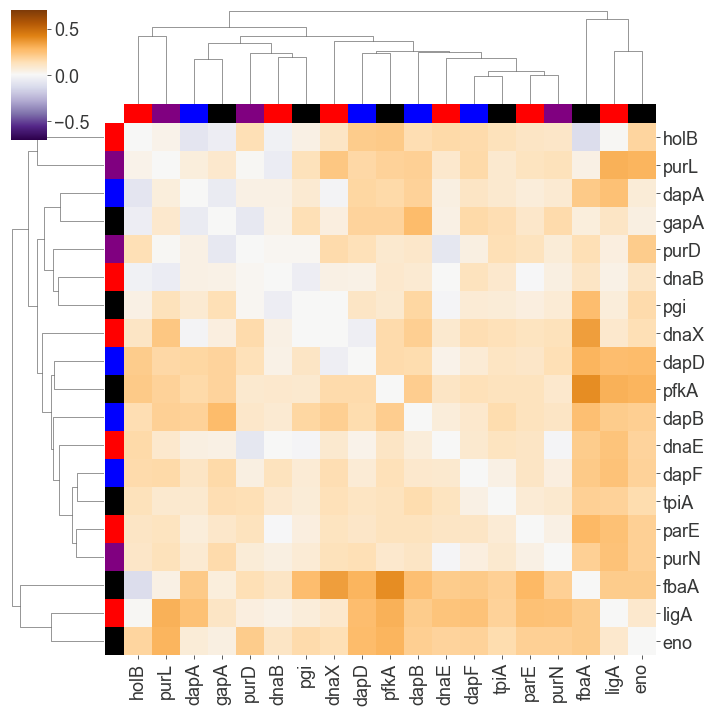

In [20]:
bliss_matrix = pd.DataFrame(np.zeros((len(gene_names), len(gene_names))), gene_names, gene_names)
fit_sem_all, _ = extract_gr_pairs(sem_df_rescale, qPCR_est, hill_est['Full Fit'])
for gene_pair, data in fit_gene_all.items():
    last_row, last_col = data.index[-1], data.columns[-1]
    if ~np.isnan(data.loc[last_row, last_col]) and ~np.isnan(data.loc[last_row, 'negC_rand_42']) and \
    ~np.isnan(data.loc['negC_rand_42', last_col]):
        bliss_matrix.loc[gene_pair[0], gene_pair[1]] = data.loc[last_row, last_col] \
                                            - data.loc['negC_rand_42', last_col]*data.loc[last_row, 'negC_rand_42']
        bliss_matrix.loc[gene_pair[1], gene_pair[0]] = bliss_matrix.loc[gene_pair[0], gene_pair[1]]
    else:  # Take average of epistasis from adjacent points
        second_last_row, second_last_col = data.index[-2], data.columns[-2]
        point1 = data.loc[second_last_row, last_col] - data.loc['negC_rand_42', last_col] \
                                                     * data.loc[second_last_row, 'negC_rand_42']
        point2 = data.loc[last_row, second_last_col] - data.loc['negC_rand_42', second_last_col] \
                                                     * data.loc[last_row, 'negC_rand_42']
        bliss_matrix.loc[gene_pair[0], gene_pair[1]] = np.nanmean([point1, point2])
        bliss_matrix.loc[gene_pair[1], gene_pair[0]] = np.nanmean([point1, point2])
sns.clustermap(bliss_matrix, vmin=-0.7, vmax=0.7, cmap='PuOr_r', dendrogram_ratio=0.15, row_colors=row_colors,
              col_colors=row_colors)
plt.savefig(f'{figure_path}/FigS6D.pdf')
plt.show()

t-test p-value for cluster 1 vs 2 seq conservation: 4.073713647682139e-30
t-test p-value for cluster 1 vs 3 seq conservation: 9.234304224144107e-112
t-test p-value for cluster 2 vs 3 seq conservation: 2.583322948372709e-33


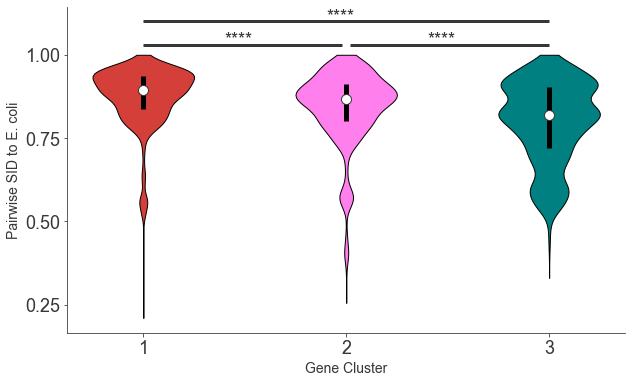

In [21]:
gene_class = [['eno','gapA','dapB','pgi','pfkA','parE','tpiA','dnaE'], ['dapA','dapF','dnaX','fbaA','dnaB','ligA'],
              ['holB','purD','purL','dapD','purN']]
fig, ax = plt.subplots(figsize=(10, 6))
val_list, q1_all, median_all, q3_all = [], [], [], []
for i, c in enumerate(gene_class):
    allvals = []
    for gene in c:
        allvals = allvals + pairSIDEcoli[gene]
    val_list.append(allvals)
    q1, m, q3 = np.percentile(np.array(allvals),[25,50,75])
    q1_all.append(q1)
    q3_all.append(q3)
    median_all.append(m)
parts = ax.violinplot(val_list, showmeans=False, showmedians=False, showextrema=False)
for i, pc in enumerate(parts['bodies']):
    if i == 0:
        pc.set_facecolor('#D43F3A')
    elif i== 1:
        pc.set_facecolor('#ff80ed')
    elif i == 2:
        pc.set_facecolor('#008080')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
ax.scatter(np.arange(1, 4), median_all, marker='o', color='white', ec='xkcd:dark gray', s=100, zorder=3)
ax.vlines(np.arange(1, 4), q1_all, q3_all, color='k', linestyle='-', lw=5)
ax.set_xticks([1, 2, 3])
ax.set_yticks([0.25, 0.5, 0.75, 1])
ax.set_ylabel('Pairwise SID to E. coli', fontsize=14)
ax.set_xlabel('Gene Cluster',fontsize=14)
ax.hlines(1.03, 1, 1.98, color='xkcd:dark gray', lw=3)
ax.hlines(1.03, 2.02, 3, color='xkcd:dark gray', lw=3)
ax.hlines(1.1, 1, 3, color='xkcd:dark gray', lw=3)
ax.text(1.4, 1.03, '****', fontsize=18)
ax.text(2.4, 1.03, '****', fontsize=18)
ax.text(1.9, 1.1, '****', fontsize=18)
for i, j in [[0, 1], [0, 2], [1, 2]]:
    t = stats.ttest_ind(val_list[i], val_list[j], equal_var=False)
    print(f't-test p-value for cluster {i+1} vs {j+1} seq conservation: {t.pvalue}')
plt.savefig(f'{figure_path}/Fig5H.pdf')
plt.show()

### Generate tables and export data

In [22]:
# Add data to Table S1
table_s1 = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Table S1', index_col='Unnamed: 0')
current = False
for i in table_s1.index:
    if table_s1.loc[i, 'sgRNA'] == 'Pathway Experiment':
        current = True
        continue
    if current:
        sgRNA = table_s1.loc[i, 'sgRNA']
        seq = table_s1.loc[i, 'Homology Sequence']
        rel_rep_eff = qPCR_est[sgRNA.split('_')[0]][sgRNA]
        table_s1.loc[i] = [sgRNA, seq, '', '', rel_rep_eff, '']
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:  
    table_s1.to_excel(writer, sheet_name='Table S1')
# Add data to Table S2
table_s2 = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Table S2', index_col='Unnamed: 0')
current = False
for i in table_s2.index:
    if table_s2.loc[i, 'Gene'] == 'Pathway Experiment':
        current = True
        continue
    if current:
        gene = table_s2.loc[i, 'Gene']
        R0 = hill_est['Full Fit'][gene][0]
        R0_low = np.round(np.quantile([hill_est[x][gene][0] for x in hill_est if x != 'Full Fit'], 0.025), 3)
        R0_high = np.round(np.quantile([hill_est[x][gene][0] for x in hill_est if x != 'Full Fit'], 0.975), 3)
        n = hill_est['Full Fit'][gene][1]
        n_low = np.round(np.quantile([hill_est[x][gene][1] for x in hill_est if x != 'Full Fit'], 0.025), 3)
        n_high = np.round(np.quantile([hill_est[x][gene][1] for x in hill_est if x != 'Full Fit'], 0.975), 3)
        table_s2.loc[i] = [gene, R0, f'[{R0_low}, {R0_high}]', n, f'[{n_low}, {n_high}]']
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:  
    table_s2.to_excel(writer, sheet_name='Table S2')
# Table S4
table_s4 = pd.DataFrame(np.full(((int(len(gene_names)*(len(gene_names)-1)/2)), 6), np.nan),
                        columns=['Gene 1', 'Gene 2', 'aij', 'aji', 'Model RMSD', 'Null RMSD'])
for i, gene_pair in enumerate(pair_avals['Full Fit']):
    boot_aij = [pair_avals[boot][gene_pair][0] for boot in pair_avals if boot != 'Full Fit']
    boot_aji = [pair_avals[boot][gene_pair][1] for boot in pair_avals if boot != 'Full Fit']
    model_rmsd = [rms_dict[boot][gene_pair] for boot in rms_dict if boot != 'Full Fit']
    null_rmsd = [rms_dict_null[boot][gene_pair] for boot in rms_dict_null if boot != 'Full Fit']
    table_s4.loc[i] = [gene_pair[0], gene_pair[1], np.round(pair_avals['Full Fit'][gene_pair][0], 3),
                       np.round(pair_avals['Full Fit'][gene_pair][1], 3),
                       np.round(rms_dict['Full Fit'][gene_pair], 3),
                       np.round(rms_dict_null['Full Fit'][gene_pair], 3)]
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:
    table_s4.to_excel(writer, sheet_name='Table S4')